# Do I want this lens?

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'svg'
# pio.renderers.default = 'iframe'

import params
from components import PrismaticLens
import xrt.backends.raycing.materials as rm
from IPython.display import display, HTML
from scipy.special import erf

## Multiprismatic lens
Multiprismatic lenses (a.k.a. crocodile or alligator lenses, depending on your favourite reptile) are parabolic one-dimensional focusing elements with variable focal distance and larger aperture compared to one-piece parabolic lenses. The following image and formula are from the PhD thesis of B. Cederstroem
![](croc.png)
$$ F = \frac{y_g \cdot y_t}{\delta \cdot L} $$
$$ \sigma _{abs} = \sqrt{\delta \cdot F \cdot L} $$

### Material choice
When putting a lens at a beamline one faces the issue that once the beam is out of the front-end (usually >10 meters away from the photon source) its cross-section already is bigger than any available lens transmission aperture. If you move further away from the photon source, the beam size increases linearly, but the absorption aperture size increases as $\sqrt{F}$, so the situation can only get worse. Hence, generally speaking, you want a lens with the shortest focal distance and largest absorption aperture as close to the photon source as possible. 

Here we calculate optimal ($y_t = y_g = 1.64 \cdot \sigma_{abs}$, according to Cederstroem) multiprismatic lens geometry for every available material (Be, Al, Graphite) for a range of photon energies we want to focus (30-90 keV).
Then we select the largest tooth height $y_t$ and length $L$ for each material for the following reasons:
1. If the lens is "too long", you can increase $y_g$ and move some teeth out of the beam effectively making it shorter. If the lens is "too short", there is no such solution.
2. Larger teeth are easier to manufacture.

In [2]:
# defining materials 
mBeryllium = rm.Material('Be', rho=1.848, kind='lens')
mAl = rm.Material('Al', rho=2.7, kind='lens')
mDiamond = rm.Material('C', rho=3.5, kind='lens')
mGraphite = rm.Material('C', rho=2.15, kind='lens')

# At SKIF the first optical element for an insertion device beamline can be put at 28 meters from the source.
# source-2F-lens-2F-sample geometry requires the least total length (source-sample distance), so it is the one we chose.
# hence 2F = 28 m, fdist = 14 m.
fdist = 14.e3  # mm
ens = np.array([30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80., 85., 90.]) * 1.e3 # eV

# creating the table for optimal geometric params and filling it using the provided PrismaticLens method
optimal_geometry = pd.DataFrame(
    columns=pd.MultiIndex.from_product([['Be', 'Al', 'Dia', 'Gr'], ['y_t [mm]', 'L [mm]', 'Apt [mm]']]),
)
optimal_geometry['E [keV]'] = (ens * 1e-3).astype(int)
optimal_geometry = optimal_geometry.set_index('E [keV]')
optimal_geometry = optimal_geometry.sort_index(axis=1)

for mat, cpt in zip((mBeryllium, mAl, mDiamond, mGraphite), ('Be', 'Al', 'Dia', 'Gr')):
    for en_ in ens:
        opt_pars = PrismaticLens.calc_optimal_params(mat, fdist, en_)
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'y_t [mm]')] = opt_pars['y_t']
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'L [mm]')] = opt_pars['L']
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'Apt [mm]')] = opt_pars['Aperture']

# since in reality we only have one lens and can not vary its tooth size, we select the best "fixed" geometry for every material
fixed_geometry = pd.DataFrame(index=['Be', 'Al', 'Dia', 'Gr'], columns=['y_t [mm]', 'L [mm]'])
for m_name in ['Be', 'Al', 'Dia', 'Gr']:
    fixed_geometry.loc[m_name, 'y_t [mm]'] = np.round(np.max(optimal_geometry.loc[:, (m_name, 'y_t [mm]')]), decimals=1)
    fixed_geometry.loc[m_name, 'L [mm]'] = int(np.round(np.max(optimal_geometry.loc[:, (m_name, 'L [mm]')]), decimals=0))

display(HTML('<center><h1>Lens param optimization</h1></center>'))
display(optimal_geometry)
display(fixed_geometry)

Al                             Be                        \
         Apt [mm]     L [mm]  y_t [mm]  Apt [mm]      L [mm]  y_t [mm]   
E [keV]                                                                  
30       1.001405   8.929917  0.273717   2.41026   82.242216  0.658804   
35       1.036582  13.030645  0.283332  2.116677   86.333604  0.578559   
40       1.055139   17.64132  0.288405  1.884684    89.40025  0.515147   
45       1.057955  22.452939  0.289174  1.698356   91.881661  0.464217   
50       1.046803  27.144013  0.286126  1.546168   94.016231  0.422619   
55        1.02795  31.676905  0.280973  1.419796   95.924605  0.388078   
60       1.002026  35.825227  0.273887  1.313435   97.695354  0.359005   
65        0.97294  39.643438  0.265937  1.222667   99.357304  0.334196   
70       0.942026  43.105127  0.257487   1.14431  100.934795  0.312778   
75       0.910416  46.220915  0.248847  1.076046  102.457358  0.294119   
80        0.87897  49.021651  0.240252  1.016049  103.936608   0.27772   
85       0.848264   51.54436  0.231859  0.962887  105.377526  0.263189   
90        0.81868  53.828416  0.223773  0.915456  106.787571  0.250225   

              Dia                             Gr                       
         Apt [mm]     L [mm]  y_t [mm]  Apt [mm]     L [mm]  y_t [mm]  
E [keV]                                                                
30       2.118662  29.804813  0.579101  2.118662  48.519463  0.579101  
35       1.930081  33.669886  0.527556  1.930081  54.811442  0.527556  
40       1.760024  36.570798  0.481073  1.760024  59.533857  0.481073  
45       1.611991  38.827845  0.440611  1.611991   63.20812  0.440611  
50        1.48433   40.64483  0.405717   1.48433  66.166003  0.405717  
55       1.374697  42.184439   0.37575  1.374697  68.672343   0.37575  
60       1.279994  43.524943  0.349865  1.279994  70.854559  0.349865  
65       1.197698  44.724614  0.327371  1.197698  72.807512  0.327371  
70       1.125682  45.820203  0.307686  1.125682  74.591028  0.307686  
75        1.06225   46.83916  0.290348   1.06225  76.249796  0.290348  
80       1.005973  47.795668  0.274966  1.005973  77.806902  0.274966  
85        0.95575  48.704011  0.261238   0.95575  79.285599  0.261238  
90       0.910672  49.573526  0.248917  0.910672   80.70109  0.248917

,y_t [mm],L [mm]
Be,0.7,107
Al,0.3,54
Dia,0.6,50
Gr,0.6,81


#### Material choice figure of merit: gain
The fundamental reason for having a lens is to have more photons on a smaller area of your sample. Gain has the following definition
$$
G = \left(\frac{Flux}{Beam \, size}\right)_{with \, lens} \Bigg/ \left(\frac{Flux}{Beam \, size}\right)_{without \, lens},
$$
Where beam size is taken at the sample, so 4F from the source in our example.

For a multiprismatic lens gain can be computed analytically (Cederstroem):
$$ 
G_{\infty} = 4 \sqrt{2 \ln 2} \cdot \frac{1}{d_0} \sqrt{F \cdot \frac{\delta}{\mu}} \cdot \mathrm{erf} \left(\frac{\mathrm{min}(y_t, y_g)}{\sqrt{F}} \sqrt{\frac{\mu}{2\delta}} \right) 
$$

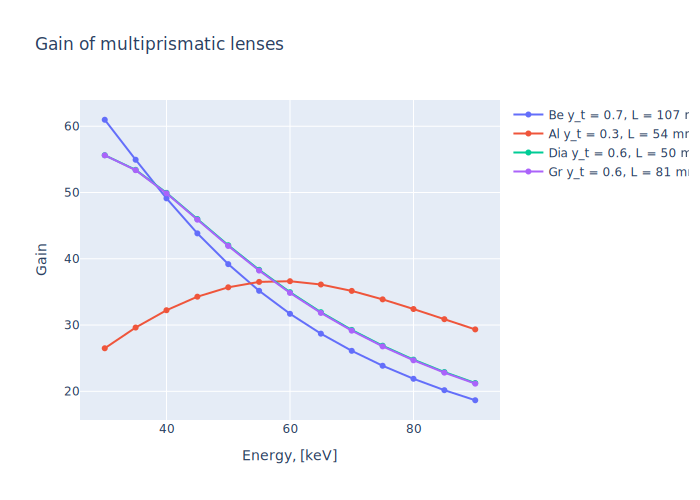

In [4]:
# defining materials
mBeryllium = rm.Material('Be', rho=1.848, kind='lens')
mAl = rm.Material('Al', rho=2.7, kind='lens')
mDiamond = rm.Material('C', rho=3.5, kind='lens')
mGraphite = rm.Material('C', rho=2.15, kind='lens')

# defining energies
# source sizes are calculated elsewhere (see undulator_applicability.ipynb, wiggler_applicability.ipynb)
fdist = 14.e3  # mm
ens = np.array([30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80., 85., 90.]) * 1.e3 # eV
source_y_sizes = np.array([0.0240305, 0.022248, 0.0208111, 0.0196209, 0.018614, 0.0177477, 0.0169922, 0.0163255, 0.0157317, 0.0151982, 0.0147156, 0.0142763, 0.013874])  # mm

# preparing figure
# fig = make_subplots(rows=1, cols=1)
fig = go.FigureWidget()
fig.update_layout(
    title=dict(text="Gain of multiprismatic lenses"),
    xaxis=dict(title=dict(text="Energy, [keV]")),
    yaxis=dict(title=dict(text="Gain"))
)

# computing results
for mat, mat_lbl in zip((mBeryllium, mAl, mDiamond, mGraphite), ('Be', 'Al', 'Dia', 'Gr')):
    # for each material selecting previously calculated optimal fixed geometry
    y_t = fixed_geometry.loc[mat_lbl, "y_t [mm]"]
    L = fixed_geometry.loc[mat_lbl, "L [mm]"]
    # computing y_g for each energy to keep the focal distance
    y_g = fdist * L * np.real(1. - mat.get_refractive_index(ens)) / y_t
    gain = .81 * (4. * np.sqrt(2. * np.log(2)) / source_y_sizes) * np.sqrt(y_g * y_t / (mat.get_absorption_coefficient(ens) * L / 10)) * erf(y_g * np.sqrt(mat.get_absorption_coefficient(ens) * L / (10 * 2 * y_g * y_t)))
    fig.add_trace(go.Line(name=mat_lbl + f" y_t = {y_t}, L = {L} mm", x=ens*1e-3, y=gain))

fig.show()